# Constrained Probabilistic Matrix Factorization

["about article of PMF - by Ruslan and Andriy"](https://papers.nips.cc/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf)

In [56]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [57]:
"setting parameters"
dimension = 10
stdv = 0.01
stdv_Y = 0.1
stdv_V = 0.1
stdv_W = 0.1
learning_rate = 0.002
momentum = 0.5
parameters = {}
epoch = 60

### Import_data
The code "import_data" loads the data set about Items following the "path". The data set is recorded on users, items, ratings, etc.<br>
Among these data, this code extracts data about users, items and ratings.<br>
−−−−−−−−−− <br>
Return<br>

data_sort : which remove and sort in order of users from data about users, items and ratings<br>
n_User and n_Item : the number of Users (or Items)

In [58]:
def import_data(path):
    data = pd.read_csv(path, sep='\t', names=['User', 'Item', 'Rating', 'Timestamp'], header=None)
    data = data.drop('Timestamp', axis=1)
    
    data_pure = data.drop_duplicates(['User','Item'], keep = 'last')
    
    data_sort = data_pure.sort_values(['User', 'Item', 'Rating'])
    
    n_User = len(data_sort.User.unique())
    n_Item = len(data_sort.Item.unique())
    
    return data_sort, n_User, n_Item

### make_R
The code "make_R" makes a matrix about ratings of data.<br>
N : users, M : items (in this code - movies)<br>
$----------$<br>
Return

R : the preference matrix $N \times M$

In [59]:
def make_R(data):
    R = data.pivot(index ='User', columns = 'Item', values = 'Rating')
    R.fillna(0, inplace = True)
    R = R.values
    return R

### make_U_V
The code "make_U_V" makes matrices U and V.<br>

U is $D \times N$ , and its transpose is user coefficient matrix<br>
V is $D \times M$ , factor matrix<br>
W is $D \times M$ , captures the effect of a user having rated a particular item on the user's feature vector<br>

also,<br>
$P(Y\mid\sigma_Y^2) = \prod_{i=1}^N \mathcal{N}(Y_i\mid0,\sigma_Y^{2}\mathbf{I})$<br>
$P(V\mid\sigma_V^2) = \prod_{i=1}^M \mathcal{N}(V_i\mid0,\sigma_V^{2}\mathbf{I})$<br>
$P(W\mid\sigma_W^2) = \prod_{i=1}^M \mathcal{N}(W_i\mid0,\sigma_W^{2}\mathbf{I})$<br>

and saves them in dictionary (named "parameters")<br>
$----------$<br>
Return

parameters

In [60]:
def make_Y_V_W(n_User, n_Item, stdv_Y, stdv_V, stdv_W, dimension, parameters):
    Y = stdv_Y*np.random.randn(dimension, n_User)
    V = stdv_V*np.random.randn(dimension, n_Item)
    W = stdv_W*np.random.randn(dimension, n_Item)
    parameters['Y'] = Y
    parameters['V'] = V
    parameters['W'] = W
    return parameters

### RMSE_calculation
The code "RMSE_calculation" calculates the root mean square error between two data sets.<br>
Denotes original_data is R and predict_data is R* then,<br>

$RMSE = \sqrt{\frac{\sum_{i=1}^N\sum_{j=1}^M\mathrm{I_{i,j}}(R_{i,j} - R*_{i,j})^2}{\sum_{i=1}^N\sum_{j=1}^M\mathrm{I_{i,j}}}}$<br>
$----------$<br>
Return<br>

np.sqrt(mse) : RMSE

In [61]:
def RMSE_calculation(original_data, predict_data):
    
    xi, yi = original_data.nonzero()
    error = 0
    count = 0
    for x, y in zip(xi,yi):
        error += pow(original_data[x,y]-predict_data[x,y], 2)
        count+=1
    mse = error/count
    return np.sqrt(mse)

### make_sum_W
The code "make_sum_W" calculates the sum of $W_{k}$ <br>

$----------$<br>
Return<br>

sum_w = $\sum_{k=1}^M\mathrm{I_{i,k}W_k}$<br>
count_W = $\sum_{k=1}^M\mathrm{I_{i,k}}$<br>
sum_W/count_W
wj = $\mathrm{I_i}$

In [62]:
def make_sum_W(parameters, R, i, dimension):
    W = parameters['W']
    wj = R[i,:].nonzero()
#     print(W.shape)
#     print(wj[0])
    sum_W = np.zeros((dimension,1))
    count_W = 0
    for k in wj[0]:

        sum_W[:,0] += W[:,k]
        count_W +=1
    return sum_W, count_W, sum_W/count_W, wj

### gradient
The code "gradient" gives a feedback to matrix Y , Vand W by using "gradient descent" method.<br>
Finding values of Y, V and W which maximize the log posterior over items and user features is equivalent to minimizing "sum of squared errors". (denoted "E")<br>
So,by "gradient descent" on "E" with learning rate and momentum to find those values.<br>
$----------$<br>
Return<br>

parameters : including the updated Y, V and W

In [63]:
def gradient(parameters, i, j, R, stdv, stdv_Y, stdv_V, stdv_W,learning_rate, moment_Y, moment_V, moment_W, I):
    Y = parameters['Y']
    V = parameters['V']
    W = parameters['W']
    
    sum_W, count_W, cal_sum_W, wj = make_sum_W(parameters, R, i, dimension)

    YV_mean = np.dot(np.array([Y[:,i]])+cal_sum_W.T, np.array([V[:,j]]).T)

    difference = R[i,j] - YV_mean[0,0]
    lambda_Y = (stdv/stdv_Y)**2
    lambda_V = (stdv/stdv_V)**2
    lambda_W = (stdv/stdv_W)**2
    copy_Y = Y.copy()
    copy_V = V.copy()
    
    learning_Y = (learning_rate*(difference*V[:,j] - lambda_Y*np.abs(Y[:,i])))
    learning_V = (learning_rate*(difference*(copy_Y[:,i] + cal_sum_W[:,0]) - lambda_V*np.abs(V[:,j])))
    
    learning_W_1 = (learning_rate*(difference*np.outer(I[:,i],V[:,j])/count_W))
    learning_W_2 = -learning_rate*lambda_W*np.abs(W[:,j])
    
    learning_W = learning_W_1 + learning_W_2
    
    Y[:,i] += learning_Y
    V[:,j] += learning_V
    W += np.mean(learning_W_1)
    W[:,j] += learning_W_2

    parameters['Y'] = Y
    parameters['V'] = V
    parameters['W'] = W

    return parameters

### make_U
The code "make_U" makes matrix U $D \times N$,<br>
which $\mathrm{U_i} = \mathrm{Y_i} + \frac{\sum_{k=1}^M\mathrm{I_{i,k}W_k}}{\sum_{k=1}^M\mathrm{I_{i,k}}}$<br>
$----------$<br>
Return<br>

$\mathrm{U}$

In [64]:
def make_U(parameters, R, n_User, dimension):
    Y = parameters['Y']
    W = parameters['W']
    U = np.zeros(Y.shape)
    for i in range(n_User):
        sum_W, count_W, cal_W, wj = make_sum_W(parameters, R, i, dimension)
        U[:,i] = Y[:,i] + cal_W[:,0]
    return U

### train_and_test
The code "train_and_test" updates Y, V and W using "gradient" function for all User and Item features which are rated.<br>

And makes approximation matrix $\hat{R} = {U^T}V$ which $\mathrm{U}$ is the results of "make_U" function.<br>
Also, $\hat{R}$ follows the normal distribution of mean $= {U^T}V$ and standard deviation $= \sigma^2$<br>

Finally, compute RMSE of R and $\hat{R}$ using "RMSE_calculation" function.<br>
$----------$<br>
Return<br>

costs : RMSE of train data sets<br>
test_costs : RMSE of test data sets<br>
parameters : the dictionary named "parameters"

In [65]:
def train_and_test(parameters, epoch, n_User, n_Item, R, R_test, I):
    costs=[]
    test_costs = []
    for i in range(epoch):
        for j in range(n_User):
            for k in range(n_Item):
                if R[j,k]>0:
                    gradient(parameters, j, k, R, stdv, stdv_Y, stdv_V, stdv_W, learning_rate, moment_Y, moment_V, moment_W, I)
        Y = parameters['Y']
        V = parameters['V']
        W = parameters['W']
        
        U = make_U(parameters, R, n_User, dimension)
        
        R_predict_mean = np.dot(U.T,V)
        R_predict = np.random.normal(R_predict_mean, stdv)

        cost = RMSE_calculation(R, R_predict)
        cost_test = RMSE_calculation(R_test, R_predict)
        costs.append(cost)
        test_costs.append(cost_test)
        if (i%10 == 0):
            print("epoch: %d ... RMSE: %f ... test_RMSE: %f" %(i, cost, cost_test))
    return costs, test_costs, parameters

### Code Execution
Prints the results of train data sets and test data sets.<br>
Then, plots of each RMSE of train and test sets.<br>
Finally, prints out the matrix Y, V and W forming approximation matrix $\hat{R}$.

start running ------%
epoch: 0 ... RMSE: 3.699516 ... test_RMSE: 3.719625
epoch: 10 ... RMSE: 1.140950 ... test_RMSE: 1.529191
epoch: 20 ... RMSE: 0.947054 ... test_RMSE: 1.231169
epoch: 30 ... RMSE: 0.897284 ... test_RMSE: 1.158103
epoch: 40 ... RMSE: 0.863983 ... test_RMSE: 1.129096
epoch: 50 ... RMSE: 0.836500 ... test_RMSE: 1.117288


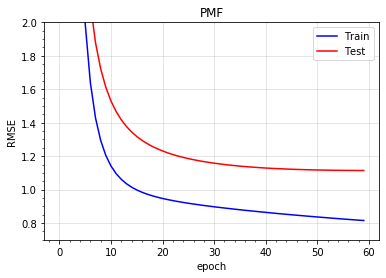

----------
[[-0.46390256 -0.30364188 -0.33067046 ... -0.35184748 -0.76458361
  -0.50868526]
 [-0.15212289 -0.04595301 -0.3590895  ... -0.15192013 -0.13853966
   0.18557155]
 [ 0.4036196   0.70697839  0.71421941 ...  0.70382809  0.69721049
   0.99624119]
 ...
 [-0.20805415  0.11809965 -0.15081006 ... -0.01195736 -0.08585625
  -0.58761138]
 [-0.77466885 -0.35381726 -0.18886304 ... -0.6232993  -0.55466552
  -1.06314577]
 [-0.73711847 -0.48398519 -0.54437677 ... -0.29457451 -0.67784864
  -0.10580695]]
----------
[[-0.44147834 -0.60797077 -0.71901546 ...  0.00430651 -0.13926423
  -0.33505991]
 [ 0.06308745  0.04512354  0.34734443 ... -0.12677441 -0.18443356
  -0.25359879]
 [ 0.20438357  0.40152457  0.22861225 ...  0.23830376 -0.04241347
   0.25899624]
 ...
 [ 0.01435074 -0.15618619 -0.55117344 ...  0.09488801 -0.19362919
   0.08945845]
 [-0.78726163 -0.40200506 -0.14412745 ... -0.18068089 -0.15735242
  -0.24641199]
 [-0.36210897 -0.65888251 -0.43742148 ... -0.10378721 -0.21211889
  -0.14859

In [66]:
print("start running ------%")
data_sort, n_User, n_Item = import_data("../ml-100k/u1.base")
test_data_sort, test_n_User, test_n_Item = import_data("../ml-100k/u1.test")
R = make_R(data_sort)
R_test = make_R(test_data_sort)
I = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(R), dtype = np.float64)

moment_Y = np.zeros(R.shape)
moment_V = np.zeros(R.shape)
moment_W = np.zeros(R.shape)

make_Y_V_W(n_User, n_Item, stdv_Y, stdv_V, stdv_W, dimension, parameters)

costs, test_costs, parameters = train_and_test(parameters, epoch, n_User, n_Item, R, R_test, I)

plt.ylim([0.70,2.0])
plt.plot(costs, 'b', label='Train')
plt.plot(test_costs, 'r', label='Test')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('PMF')
plt.minorticks_on()
plt.grid(b=True, which = 'major', color = '#666666', linestyle = '-', alpha = 0.2)
plt.legend()

plt.show()
print('----------')
print(parameters['Y'])
print('----------')
print(parameters['V'])
print('----------')
print(parameters['W'])